<a href="https://colab.research.google.com/github/tiago121/health_insurance_project/blob/main/P__Health_Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy  as np
import pandas as pd
#import boruta as bt
import scikitplot as skplt
import pickle

import seaborn as sns

from matplotlib import pyplot as plt

from sklearn import preprocessing   as pp
from sklearn import linear_model    as lm
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh

In [ ]:
df1 = pd.read_csv('/content/trieno_health_insurance.csv')

In [ ]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# rename 
df1.columns = cols_new

In [ ]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [ ]:
df2 = df1.copy()

# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else "less_1_year")

In [ ]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,less_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,less_1_year,0,27496.0,152.0,39,0


In [ ]:
df2['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

In [ ]:
df5 = df2.copy()

## Data Preparation

In [ ]:
X = df2.drop( 'response', axis=1 )
y = df2['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.90 )

df5 = pd.concat( [x_train, y_train], axis=1 )

In [ ]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

In [ ]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values)

In [ ]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

In [ ]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

## Models

In [ ]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train = df5[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation.copy()

In [ ]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction - Poder de GENERALIZACAO 
yhat_knn = knn_model.predict_proba( x_val )

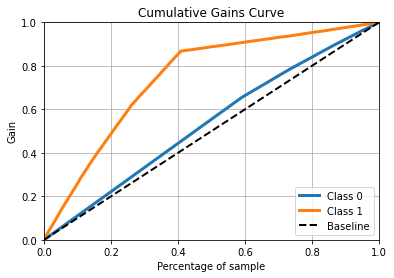

In [ ]:
 # Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

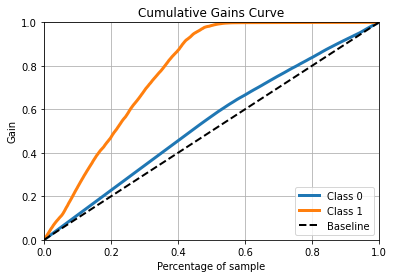

In [ ]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

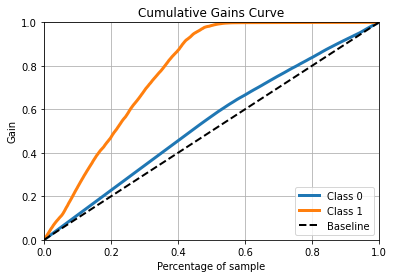

In [ ]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

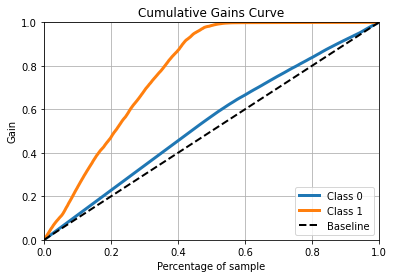

In [ ]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

In [ ]:
# model definition
rf = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = rf.predict_proba( x_val )

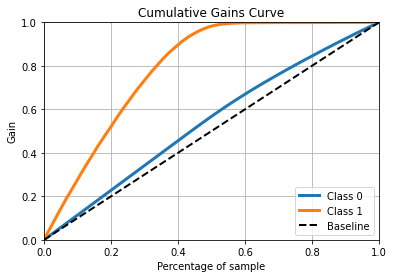

In [ ]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf );

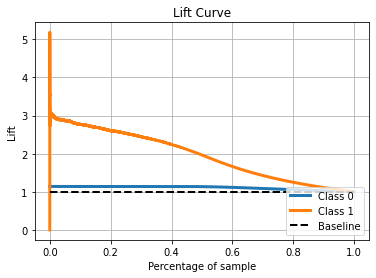

In [ ]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_rf );

In [ ]:
len(yhat_rf)

342999

In [ ]:
len(y_val)

342999

## Model Performance

In [ ]:
def precision_at_k( data, k=10 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return ( data.loc[ k, 'precision_at_k'], data )

In [ ]:
def recall_at_k( data, k=15 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'], data )

In [ ]:
# copy dataframe
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_rf[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df8, k=20 )

# compute recall at k
recall_at_15, data = recall_at_k( df8, k=15 )

In [ ]:
import numpy as np
from sklearn.metrics import top_k_accuracy_score

y_true = np.array([0, 1, 2, 2])
y_score = np.array([[0.5, 0.2, 0.2],  # 0 is in top 2
                    [0.3, 0.4, 0.2],  # 1 is in top 2
                    [0.2, 0.4, 0.3],  # 2 is in top 2
                    [0.7, 0.2, 0.1]]) # 2 isn't in top 2

top_k_accuracy_score(y_true, y_score, k=2)

0.75

In [ ]:
y_true = np.array( [1, 0, 1, 1, 0, 1, 0, 0] )
y_score = np.array( [])

## Cummulative Curve Manually

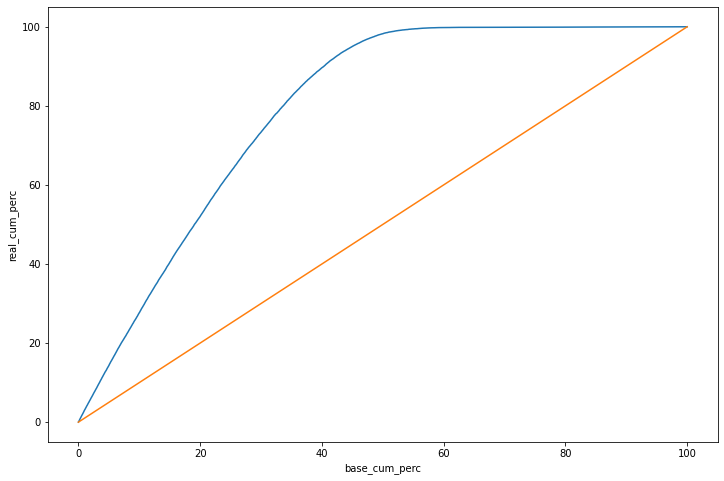

In [ ]:
results = pd.DataFrame()
results['prediction'] = yhat_rf[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=results )
sns.lineplot( x='base_cum_perc', y='baseline', data=results )

In [ ]:
results.head(12)

,prediction,real,real_cum,real_cum_perc,base,base_cum_perc,baseline
123190,0.924,0,0,0.000000,1,0.000292,0.000292
257391,0.914,1,1,0.002375,2,0.000583,0.000583
242612,0.901,0,1,0.002375,3,0.000875,0.000875
272058,0.889,0,1,0.002375,4,0.001166,0.001166
206731,0.887,1,2,0.004751,5,0.001458,0.001458
285130,0.883,1,3,0.007126,6,0.001749,0.001749
23950,0.877,0,3,0.007126,7,0.002041,0.002041
116332,0.874,1,4,0.009501,8,0.002332,0.002332
76181,0.873,1,5,0.011876,9,0.002624,0.002624
68950,0.869,1,6,0.014252,10,0.002915,0.002915


## Lift Curve Manually

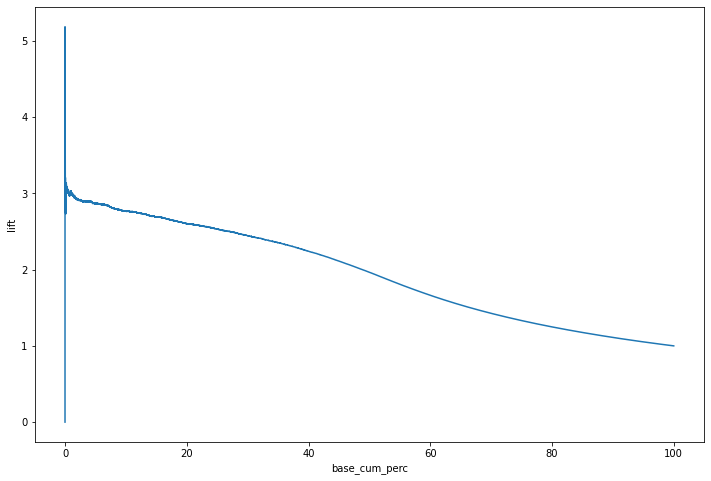

In [ ]:
results = pd.DataFrame()
results['prediction'] = yhat_rf[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='lift', data=results )

## ROI Curve Manually

In [ ]:
results = pd.DataFrame()
results['prediction'] = yhat_rf[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

# ROI Curve


#plt.figure( figsize=(12,8))
#sns.lineplot( x='base_cum_perc', y='lift', data=results )

In [ ]:
results.head()

,prediction,real,real_cum,real_cum_perc,base,base_cum_perc,baseline,lift
123190,0.924,0,0,0.000000,1,0.000292,0.000292,0.000000
257391,0.914,1,1,0.002375,2,0.000583,0.000583,4.073622
242612,0.901,0,1,0.002375,3,0.000875,0.000875,2.715748
272058,0.889,0,1,0.002375,4,0.001166,0.001166,2.036811
206731,0.887,1,2,0.004751,5,0.001458,0.001458,3.258898


In [ ]:
# Compute bucket
results['bucket'] = results['prediction'].apply( lambda x: 0.9 if x >= 0.90 else 
                                                           0.8 if ( x >= 0.80) & ( x <= 0.90 ) else 
                                                           0.7 if ( x >= 0.70) & ( x <= 0.80 ) else 
                                                           0.6 if ( x >= 0.60) & ( x <= 0.70 ) else 
                                                           0.5 if ( x >= 0.50) & ( x <= 0.60 ) else 
                                                           0.4 if ( x >= 0.40) & ( x <= 0.50 ) else 
                                                           0.3 if ( x >= 0.30) & ( x <= 0.40 ) else 
                                                           0.2 if ( x >= 0.20) & ( x <= 0.30 ) else 
                                                           0.1 if ( x >= 0.10) & ( x <= 0.20 ) else 0.01 )

#  Aggregate clients among buckets
df = results[['prediction','bucket']].groupby( 'bucket' ).agg( {'min', 'count'} ).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Compute revenue and cost
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']

df['base'] = df['clients'].sort_values( ascending=True ).cumsum() / df['clients'].sum()

# revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values( 'index', ascending=False )
df

,index,clients,propensity_score,gross_revenue,cost,base,revenue
9,0.90,0.901,3,108.12,3.604,1.000000,104.516
8,0.80,0.800,100,3200.00,3.200,0.799822,3196.800
7,0.70,0.700,794,22232.00,2.800,0.622084,22229.200
6,0.60,0.600,3130,75120.00,2.400,0.466563,75117.600
5,0.50,0.500,8388,167760.00,2.000,0.333259,167758.000
4,0.40,0.400,17468,279488.00,1.600,0.222173,279486.400
3,0.30,0.300,29339,352068.00,1.200,0.133304,352066.800
2,0.20,0.200,39199,313592.00,0.800,0.066652,313591.200
1,0.10,0.100,40114,160456.00,0.400,0.022217,160455.600
0,0.01,0.000,204464,0.00,0.000,0.000000,0.000


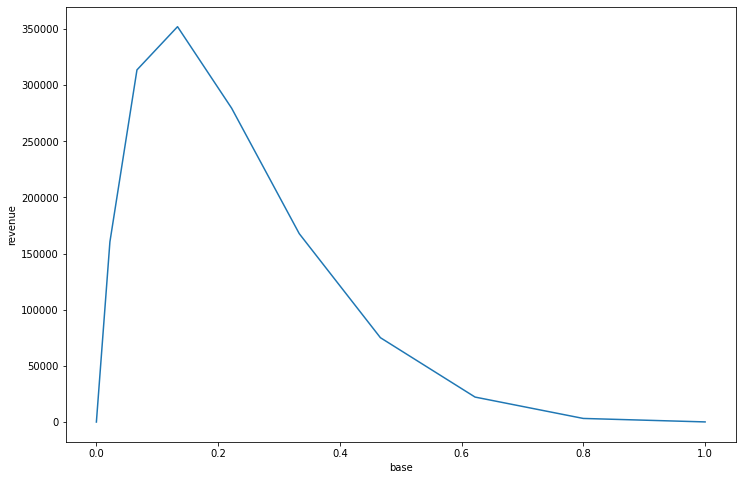

In [ ]:
plt.figure( figsize=(12,8))
aux = df[df['propensity_score'] >= 0.1]
sns.lineplot( x='base', y='revenue', data=aux )

## Observações:

1. gráfico de lucro não condiz com dados. Olhar mais exemplos
2. dados de lucro que criei são diferentes dos do meigarom, entender por que
3. como plotar uma função def no matplotlib?

## Implementação da minha curva de lucro

In [ ]:
population_size = 100000
target_incidence = 0.12
reward_target = 50
cost_campaign = 2

def profit(perc_targets, perc_selected, population_size, reward_target, cost_campaign):
    cost = cost_campaign * perc_selected * population_size
    reward = reward_target * perc_targets * perc_selected * population_size
    return (reward - cost)

perc_selected = 0.20
lift = 2.5
perc_targets = lift * target_incidence
print(profit(perc_targets, perc_selected, population_size, reward_target, cost_campaign))






260000.0


In [ ]:
profit_40 = profit( target_incidence * lift , 0.1, population_size, cost_campaign, reward_target)
profit_40 

-494000.0

In [ ]:
plt.figure( figsize=(12,8))
aux = df[df['propensity_score'] >= 0.1]
sns.lineplot( x='base', y='revenue', data=aux )